# Greedy Filter Pruning


In this notebook we review a couple of experiments performed on Plain20 using Distiller's version of greedy filter pruning.  This implementation is very similar to the greed algorithms defined in [1] and [2].

This is another means to explore the network sub-space around a pre-trained model: by small greedy and iterative greedy filter-subtraction operations.  

We want to answer the question: *how important is the duration of the short-term fine-tuning (see NetAdapt for definition of short-term FT)?*

### Resources

**[1] Structural Compression of Convolutional Neural Networks Based on Greedy Filter Pruning**<br>
*Reza Abbasi-Asl, Bin Yu*
https://arxiv.org/abs/1705.07356

**[2] NetAdapt: Platform-Aware Neural Network Adaptation for Mobile Applications**<br>
*Tien-Ju Yang, Andrew Howard, Bo Chen, Xiao Zhang, Alec Go, Mark Sandler, Vivienne Sze, Hartwig Adam*<br>
https://arxiv.org/abs/1804.03230, ECCV 2018

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

In [8]:
fname1 = "../classifier_compression/latest_log_dir/netadapt.csv"

fname1 = "../automated_deep_compression/sample_logs/greedy_search/2019.01.08-185015/greedy.csv"
fname2 = "../automated_deep_compression/sample_logs/greedy_search/2019.01.09-010040/greedy.csv"
df1 = pd.read_csv(fname1)
df2 = pd.read_csv(fname2)

In [9]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    if y <= 1:
        y = 100 * y
    s = "{:.1f}".format(y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
def plot_2d_embeddings(plots): # top1, normalized_macs, cmap_str):
    plt.figure(figsize=(15,7))        
    plt.title('Projection of Discovered Networks') # ({})'.format(len(top1)))     
    plt.xlabel('Normalized MACs')
    plt.ylabel('Top1 Accuracy')

    # Create the formatter using the function to_percent. This multiplies all the
    # default labels by 100, making them all percentages
    formatter = FuncFormatter(to_percent)

    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Use color gradients to show the "age" of the network:
    # Lighter networks were discovered earlier than darker ones.
    for plot in plots:
        cm = plt.get_cmap(plot[2])
        top1 = plot[0]
        normalized_macs = plot[1]
        color_grad = [cm(float(i)/len(top1)) for i in range(len(top1))]
        plt.scatter(normalized_macs, top1, color=color_grad, s=80, edgecolors='gray', marker='o');

plots = [(df1['top1'], df1['normalized_macs'], "Greens"),
         (df2['top1'], df2['normalized_macs'], "Reds")]

## Experiment1: Short-term fine-tuning using 20% of the training DS

Run NetAdapt with 1 epoch of short-term fine-tuning which uses 20% of the training dataset, for one epoch.
```
time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=checkpoint.plain20_cifar.pth.tar --greedy --vs=0.8
```

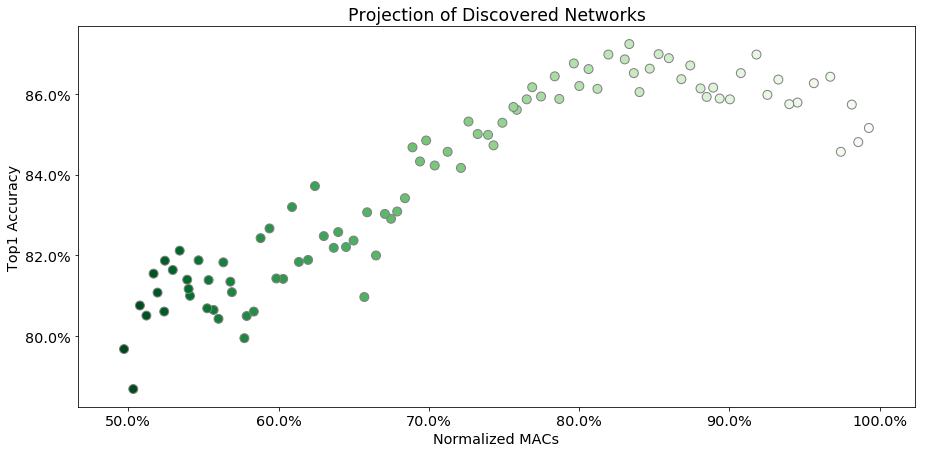

In [10]:
plot_2d_embeddings(plots[:-1])

### Long-term fine-tuning (40 epochs)
```
time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --epochs=40 --lr=0.005 -p=50  --resume=logs/2019.01.08-185015/netadapt_0.5_checkpoint.pth.tar --vs=0
```

**==> Best Top1: 88.880 on Epoch: 37**

## Experiment2: Short-term fine-tuning using 100% of the training DS

We repeat the NetAdapt training, but this time with 1 epoch of short-term fine-tuning which uses 100% of the training dataset, for one epoch.
```
time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=checkpoint.plain20_cifar.pth.tar --greedy
```

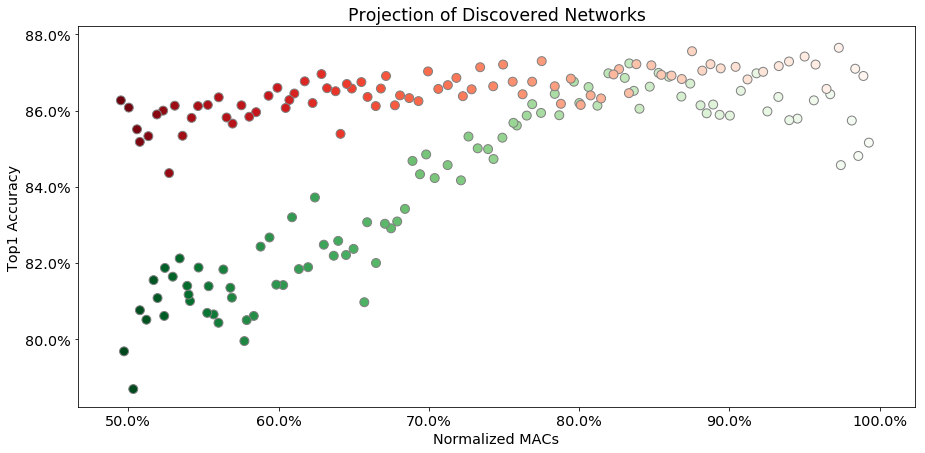

In [6]:
plot_2d_embeddings(plots)

time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --resume=checkpoint.plain20_cifar.pth.tar --netadapt
```
==> using cifar10 dataset
=> creating plain20_cifar model for CIFAR10
Invoking create_thinning_recipe_filters
In tensor module.layer3.0.conv2.weight found 4/48 zero filters
Created, applied and saved a thinning recipe
Iteration 83: 86.27 module.layer3.0.conv2.weight 0.49511363636363637
--- test ---------------------
10000 samples (256 per mini-batch)
Test: [   10/   39]    Loss 0.451831    Top1 86.367188    Top5 99.375000
Test: [   20/   39]    Loss 0.443609    Top1 86.347656    Top5 99.257812
Test: [   30/   39]    Loss 0.432273    Top1 86.549479    Top5 99.375000
Test: [   40/   39]    Loss 0.439493    Top1 86.390000    Top5 99.450000
==> Top1: 86.390    Top5: 99.450    Loss: 0.439

86.39 99.45 0.4394926078617573
Saving checkpoint to: logs/2019.01.09-010040/netadapt_0.5_checkpoint.pth.tar

Log file for this run: /home/cvds_lab/nzmora/pytorch_workspace/distiller/examples/classifier_compression/logs/2019.01.09-010040/2019.01.09-010040.log

real    258m19.600s
user    781m11.641s
sys     164m58.532s
```

### Long-term fine-tuning (40 epochs)
```
time python3 compress_classifier.py --arch=plain20_cifar ../../../data.cifar --epochs=40 --lr=0.005 -p=50  --resume=logs/2019.01.09-010040/netadapt_0.5_checkpoint.pth.tar --vs=0
```

**==> Best Top1: 90.200 on Epoch: 29**

## Conclusion

The longer short-term fine-tuning of the second experiment adds considerable time to the experiment duration, but produces near-dense Top1 results.  

The question is why?  How do these networks structurally differ?